In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1 -y
# !pip install accelerate
# !pip install salesforce-lavis


In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
sys.setrecursionlimit(5000)

# !conda install cudnn=8.4.1

/opt/conda/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/baseline/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/envs/baseline/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
# ob_df_raw           = lumnis.get_historical_data("orderbook_snapshot_5", "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")


In [4]:
temp_df_btc         = rolling_mean_diff(temp_df_btc_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_eth         = rolling_mean_diff(temp_df_eth_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_xmr         = rolling_mean_diff(temp_df_xmr_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')

cols                = temp_df_btc.columns #['close', 'volume'] #
max_seq_len         = 150

btc_array           = create_3d_array(temp_df_btc[cols], temp_df_btc.index, max_seq_len)
eth_array           = create_3d_array(temp_df_eth[cols], temp_df_eth.index, max_seq_len)
xmr_array           = create_3d_array(temp_df_xmr[cols], temp_df_xmr.index, max_seq_len)


In [5]:
univariate_array_eth         = create_3d_array(temp_df_eth_raw[['close']], temp_df_eth_raw.index, max_seq_len)
univariate_array_btc         = create_3d_array(temp_df_btc_raw[['close']], temp_df_btc_raw.index, max_seq_len)
univariate_array_xmr         = create_3d_array(temp_df_xmr_raw[['close']], temp_df_xmr_raw.index, max_seq_len)

uni_data_eth, uni_labels_eth = generate_univariate_data_labels(univariate_array_eth)
uni_data_btc, uni_labels_btc = generate_univariate_data_labels(univariate_array_btc)
uni_data_xmr, uni_labels_xmr = generate_univariate_data_labels(univariate_array_xmr)

uni_data                     = np.concatenate((uni_data_eth, uni_data_btc, uni_data_xmr), axis=0)
uni_labels                   = np.concatenate((uni_labels_eth, uni_labels_btc, uni_labels_xmr), axis=0)

print(uni_data.shape, uni_labels.shape)

(56762, 150, 1) (56762, 150, 1)


In [6]:
data_btc, labels_btc = generate_data_labels_from_3d_array(btc_array)
data_eth, labels_eth = generate_data_labels_from_3d_array(eth_array)
data_xmr, labels_xmr = generate_data_labels_from_3d_array(xmr_array)

<Axes: >

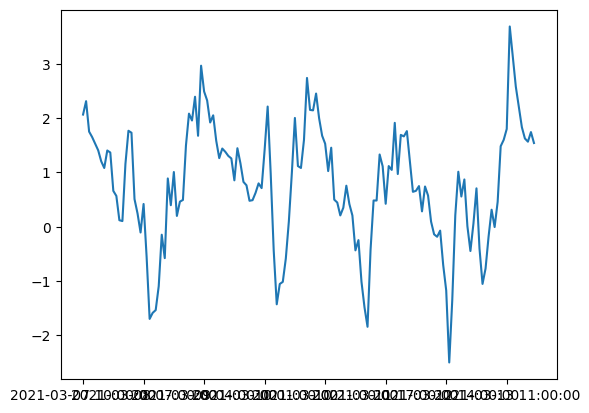

In [11]:
temp_df_btc['open_standard_25'][0:150].plot()

In [16]:
import contextlib
def dataframe_to_image(df, legend=None):
    buf = io.BytesIO()
    plt.figure()
    
    with contextlib.redirect_stdout(io.StringIO()):
        df.reset_index(drop=True).plot(legend=legend)
        plt.savefig(buf, format='png')

    buf.seek(0)
    image = Image.open(buf)
    plt.close()
    return image

In [20]:
raw_image  = dataframe_to_image( temp_df_btc[['open_standard_25']][0:150] )

<Figure size 640x480 with 0 Axes>

In [ ]:
temp_df_btc

In [23]:
import torch
from lavis.models import load_model_and_preprocess

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loads BLIP-2 pre-trained model
model, vis_processors, _ = load_model_and_preprocess(name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device)
# prepare the image
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

100%|██████████| 1.89G/1.89G [00:10<00:00, 187MB/s] 

In [ ]:
model.generate({"image": image, "prompt": "Question: Is the stock price expected to go up or down? Answer:"})
